In [4]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2_05q31m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2_05q31m
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done


In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [7]:
import json

def is_coco_format(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Check if the main keys are present
        if not all(key in data for key in ["images", "annotations", "categories"]):
            return False

        # Check if 'images' has the required keys
        for image in data["images"]:
            if not all(key in image for key in ["height", "width", "id", "file_name"]):
                return False

        # Check if 'annotations' has the required keys
        for annotation in data["annotations"]:
            if not all(key in annotation for key in ["iscrowd", "image_id", "bbox", "category_id", "id", "area"]):
                return False

        # Check if 'categories' has the required keys
        for category in data["categories"]:
            if not all(key in category for key in ["id", "name"]):
                return False

        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [8]:
file_path = '/home/hous/Desktop/TEST/_annotations.coco.json'
result = is_coco_format(file_path)
print(f"Is COCO Format: {result}")

Is COCO Format: True


In [9]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/hous/Desktop/TEST/_annotations.coco.json", "/home/hous/Desktop/TEST/train")

In [10]:
from detectron2.data import DatasetCatalog

def is_dataset_registered(name):
    return name in DatasetCatalog.list()

dataset_name = "my_dataset_train"
if is_dataset_registered(dataset_name):
    print(f"The dataset '{dataset_name}' is registered.")
else:
    print(f"The dataset '{dataset_name}' is not registered.")

The dataset 'my_dataset_train' is registered.


WARNING [11/11 09:23:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/11 09:23:56 d2.data.datasets.coco]: Loaded 5784 images in COCO format from /home/hous/Desktop/TEST/_annotations.coco.json


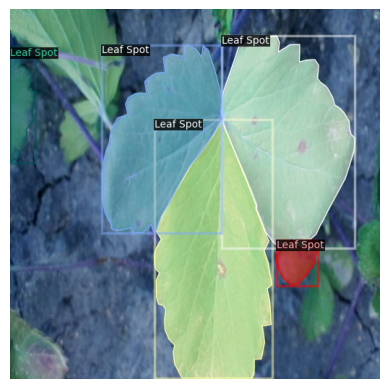

In [11]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Load the dataset and retrieve metadata
dataset_dicts = DatasetCatalog.get(dataset_name)
dataset_metadata = MetadataCatalog.get(dataset_name)

# Pick a random sample from the dataset
sample = random.choice(dataset_dicts)

# Read the image
img = cv2.imread(sample["file_name"])

# Create a Visualizer object
visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

# Visualize the annotations
vis_output = visualizer.draw_dataset_dict(sample)

# Display the image using Matplotlib
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

WARNING [11/11 09:23:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/11 09:23:57 d2.data.datasets.coco]: Loaded 5784 images in COCO format from /home/hous/Desktop/TEST/_annotations.coco.json
Sample from training data:
WARNING [11/11 09:23:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/11 09:23:57 d2.data.datasets.coco]: Loaded 5784 images in COCO format from /home/hous/Desktop/TEST/_annotations.coco.json


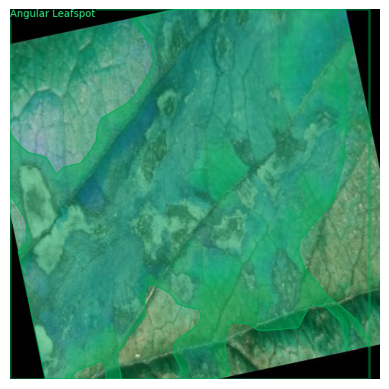

Sample from validation data:


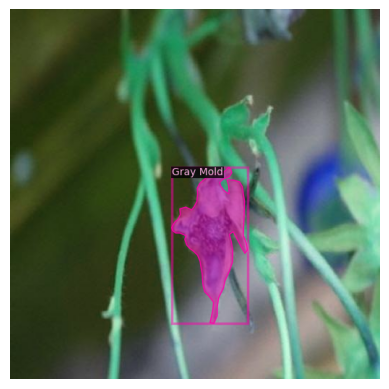

In [12]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

def plot_sample(dataset_name):
    # Load the dataset and retrieve metadata
    dataset_dicts = DatasetCatalog.get(dataset_name)
    dataset_metadata = MetadataCatalog.get(dataset_name)

    # Pick a random sample from the dataset
    sample = random.choice(dataset_dicts)

    # Read the image
    img = cv2.imread(sample["file_name"])

    # Create a Visualizer object
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

    # Visualize the annotations
    vis_output = visualizer.draw_dataset_dict(sample)

    # Display the image using Matplotlib
    plt.imshow(vis_output.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

# Name of the original registered dataset
original_dataset_name = "my_dataset_train"

# Load the dataset
dataset_dicts = DatasetCatalog.get(original_dataset_name)

# Shuffle the dataset and split into training and validation sets
random.shuffle(dataset_dicts)
train_size = int(0.8 * len(dataset_dicts))
train_dataset = dataset_dicts[:train_size]
val_dataset = dataset_dicts[train_size:]

# Register the validation dataset
def register_dataset(name, data):
    # Reuse the metadata of the original dataset
    original_metadata = MetadataCatalog.get(original_dataset_name)

    # Register the new dataset
    DatasetCatalog.register(name, lambda: data)

    # Create a new metadata object and set the attributes
    metadata = MetadataCatalog.get(name)
    metadata.set(thing_classes=original_metadata.get("thing_classes"))

val_name = "my_dataset_val"
register_dataset(val_name, val_dataset)

# Plot a sample from the training data (already registered)
print("Sample from training data:")
plot_sample(original_dataset_name)

# Plot a sample from the validation data
print("Sample from validation data:")
plot_sample(val_name)

In [13]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

# Define hyperparameters
batch_size = 4  # Example batch size

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (3000, 4000)  # Points to decrease the learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# Learning rate scheduler configuration
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.1  # Learning rate reduction factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Regularization - weight decay

# Set up output directory
output_dir = "/home/hous/Desktop/TEST/output_strawberry"
os.makedirs(output_dir, exist_ok=True)
cfg.OUTPUT_DIR = output_dir

# Initialize the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/10 23:30:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

[11/10 23:30:14 d2.engine.train_loop]: Starting training from iteration 0


2023-11-10 23:30:15.325727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 23:30:16.429563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/10 23:30:46 d2.utils.events]:  eta: 1:41:27  iter: 19  total_loss: 3.101  loss_cls: 1.858  loss_box_reg: 0.4918  loss_mask: 0.6926  loss_rpn_cls: 0.06791  loss_rpn_loc: 0.02013    time: 1.2845  last_time: 1.1794  data_time: 0.0123  last_data_time: 0.0053   lr: 4.5417e-06  max_mem: 2930M
[11/10 23:31:12 d2.utils.events]:  eta: 1:44:33  iter: 39  total_loss: 3.088  loss_cls: 1.687  loss_box_reg: 0.5062  loss_mask: 0.6918  loss_rpn_cls: 0.08653  loss_rpn_loc: 0.02251    time: 1.2895  last_time: 1.2676  data_time: 0.0060  last_data_time: 0.0213   lr: 9.0592e-06  max_mem: 3095M
[11/10 23:31:37 d2.utils.events]:  eta: 1:43:09  iter: 59  total_loss: 2.766  loss_cls: 1.413  loss_box_reg: 0.5365  loss_mask: 0.6902  loss_rpn_cls: 0.09977  loss_rpn_loc: 0.02566    time: 1.2798  last_time: 1.1837  data_time: 0.0053  last_data_time: 0.0050   lr: 1.3577e-05  max_mem: 3095M
[11/10 23:32:04 d2.utils.events]:  eta: 1:43:18  iter: 79  total_loss: 2.221  loss_cls: 1.022  loss_box_reg: 0.45  loss_mask

In [12]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-11 08:47:55.705862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Traceback (most recent call last):
  File "/home/hous/anaconda3/envs/torch/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/home/hous/.local/lib/python3.10/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/hous/.local/lib/python3.10/site-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-pack

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import random
import cv2

# Name of the validation dataset
dataset_name = "my_dataset_val"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

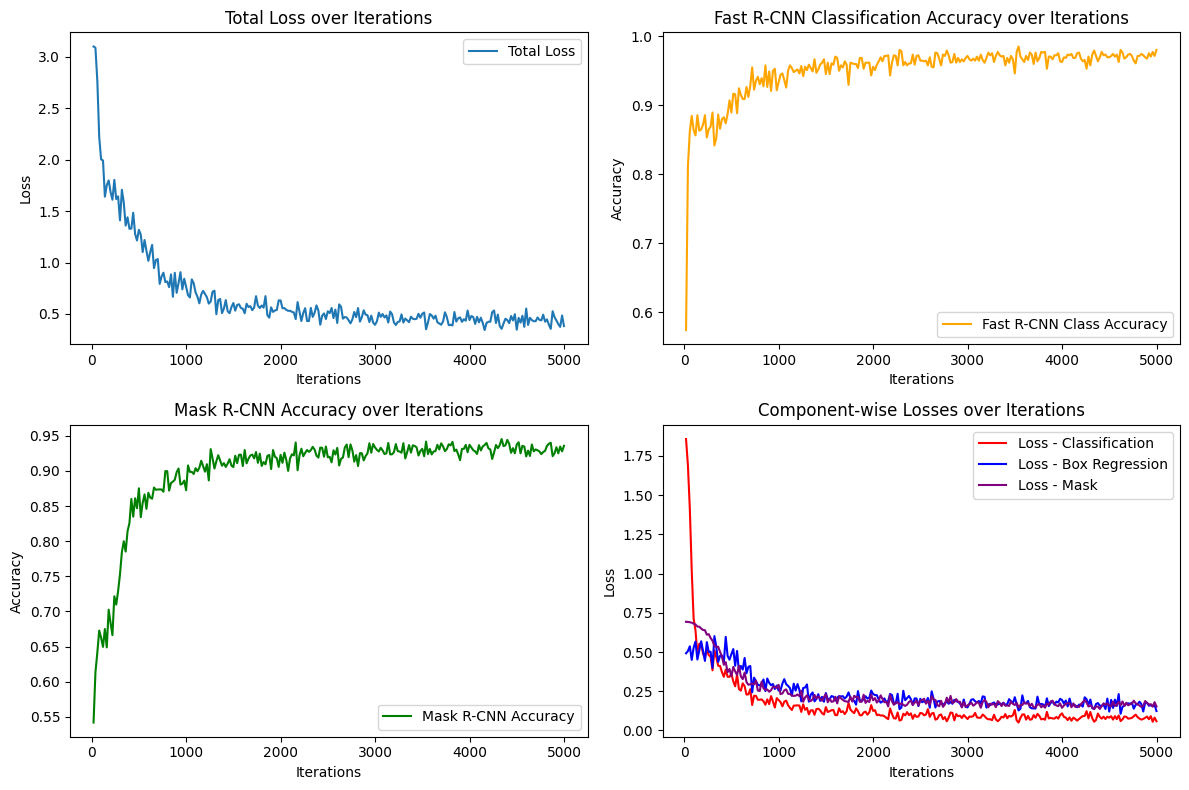

In [14]:
import json
import matplotlib.pyplot as plt

# Path to your metrics.json file
metrics_file = '/home/hous/Desktop/TEST/output_strawberry/metrics.json'  # Update this path

# Read the file and parse the JSON
with open(metrics_file, 'r') as file:
    lines = file.readlines()

metrics = [json.loads(line) for line in lines]

# Initialize lists for metrics
iterations = []
total_losses = []
cls_accuracies = []
mask_accuracies = []
loss_cls = []
loss_box_reg = []
loss_mask = []

# Extract metrics
for m in metrics:
    if all(k in m for k in ['iteration', 'total_loss', 'fast_rcnn/cls_accuracy', 'mask_rcnn/accuracy', 'loss_cls', 'loss_box_reg', 'loss_mask']):
        iterations.append(m['iteration'])
        total_losses.append(m['total_loss'])
        cls_accuracies.append(m['fast_rcnn/cls_accuracy'])
        mask_accuracies.append(m['mask_rcnn/accuracy'])
        loss_cls.append(m['loss_cls'])
        loss_box_reg.append(m['loss_box_reg'])
        loss_mask.append(m['loss_mask'])

# Plotting
plt.figure(figsize=(12, 8))

# Total loss
plt.subplot(2, 2, 1)
plt.plot(iterations, total_losses, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total Loss over Iterations')
plt.legend()

# Classification Accuracy
plt.subplot(2, 2, 2)
plt.plot(iterations, cls_accuracies, label='Fast R-CNN Class Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Fast R-CNN Classification Accuracy over Iterations')
plt.legend()

# Mask Accuracy
plt.subplot(2, 2, 3)
plt.plot(iterations, mask_accuracies, label='Mask R-CNN Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Mask R-CNN Accuracy over Iterations')
plt.legend()

# Losses for Classification, Box Regression, and Mask
plt.subplot(2, 2, 4)
plt.plot(iterations, loss_cls, label='Loss - Classification', color='red')
plt.plot(iterations, loss_box_reg, label='Loss - Box Regression', color='blue')
plt.plot(iterations, loss_mask, label='Loss - Mask', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Component-wise Losses over Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/home/hous/Desktop/TEST/output_strawberry")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

WARNING [11/11 09:25:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/11 09:25:25 d2.evaluation.coco_evaluation]: Trying to convert 'my_dataset_val' to COCO format ...
[11/11 09:25:25 d2.data.datasets.coco]: Converting annotations of dataset 'my_dataset_val' to COCO format ...)
[11/11 09:25:25 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/11 09:25:25 d2.data.datasets.coco]: Conversion finished, #images: 1157, #annotations: 2838
[11/11 09:25:25 d2.data.datasets.coco]: Caching COCO format annotations at '/home/hous/Desktop/TEST/output_strawberry/my_dataset_val_coco_format.json' ...
[11/11 09:25:25 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| strawberry-